# Relation of schooling years to education

In this notebook we will analyze the correlation between years of education and the proficiency in certain skills.

First we will load all the data and extract the relevant indicators (see notebook `11` for details):

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
import edstats_utils as edstats
%matplotlib inline

# some pandas options
pd.set_option('display.max_colwidth', -1)

# load the relevant data
datapath = "./datasets/edstats"
df_country = pd.read_csv(os.path.join(datapath, "EdStatsCountry.csv"))
df_data = pd.read_csv(os.path.join(datapath, "EdStatsData.csv"))
df_series = pd.read_csv(os.path.join(datapath, "EdStatsSeries.csv"))
df_note = pd.read_csv(os.path.join(datapath, "EdStatsFootNote.csv"))
df_cseries = pd.read_csv(os.path.join(datapath, "EdStatsCountry-Series.csv"))

Now we are using the extraction functions defined in `edstats` to extract the relevant data we are going to need

In [2]:
# retrieve the proficiency skills
df_adult_prof = edstats.retrieve_skill_piaac(df_data)
df_pisa = edstats.retrieve_skill_pisa(df_data)
df_stud_bm = edstats.retrieve_skill_timss(df_data)
df_stud_prof = edstats.retrieve_skill_llece(df_data)

# retrieve the data for mean schooling years
df_wp_meanschool = edstats.retrieve_wittgenstein_mean_schooling(df_data)
df_bl_eduperc = edstats.retrieve_barrolee_percentage(df_data)
df_bl_eduyears = edstats.retrieve_barrolee_years(df_data)
df_ed_years = edstats.retrieve_education_length(df_data)

We are using different indicators, however the first step will be to identify, which provides the best data source.

## Which skills to use

Let us first take a look at the skill data. The main questions we want to answer:

* What is the coverage of the data across countries and years?
* Which skills do we have?
* Can we identify certain trends regarding the skills?


In [3]:
# find the years available for the indicators
print(df_adult_prof.dropna(axis=1, how='all').columns)
print(df_pisa.dropna(axis=1, how='all').columns)
print(df_stud_bm.dropna(axis=1, how='all').columns)
print(df_stud_prof.dropna(axis=1, how='all').columns)

ls = [
    ('PIAAC', ['2012', '2015'], df_adult_prof), 
    ("PISA", ['2000', '2003', '2006', '2009', '2012', '2015'], df_pisa), 
    ('TIMSS', ['1995', '1999', '2003', '2007', '2011', '2015'], df_stud_bm),
    ('LLECE', ['2006', '2013'], df_stud_prof)
]

# find the number of countries for each indicator
for nm, yrs, df in ls:
    print("\n{} Countries for subjects:".format(nm))
    print("-"*30)
    print(df[df[yrs].isnull().min(axis=1) == False].groupby(['Indicator Name', 'subject']).count().groupby('subject').max()[yrs])

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '2012', '2015', 'indicator', 'gender', 'subject', 'level'],
      dtype='object')
Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '2000', '2003', '2006', '2009', '2012', '2015', 'indicator', 'gender',
       'subject', 'level'],
      dtype='object')
Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1995', '1999', '2003', '2007', '2011', '2015', 'indicator', 'gender',
       'subject', 'achievement'],
      dtype='object')
Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '2006', '2013', 'indicator', 'gender', 'grade', 'subject', 'level'],
      dtype='object')

PIAAC Countries for subjects:
------------------------------
                                                 2012  2015
subject                                                    
literacy                                         22    8   
numeracy 

We can see that the global coverage is quite low, with the adult proficiency score only having 22 countries and the Pisa Scores being available for only 71 countries in 2015. We also see a strong variance across the years. For the current question I will use the PIAAC (`df_adult_prof`) data, as we want to check how different years of education change the proficiency in certain skills of the entire population.

Next lets visualize the data over the years:

In [4]:
# clean the dataset and add the region
ls_adult_years = ['2012', '2015']
df_adpr_clean = edstats.filter_years(df_adult_prof, ls_adult_years).dropna(axis=1, how='all')
df_adpr_clean = df_adpr_clean[df_adpr_clean.iloc[:, 4:6].isnull().min(axis=1) == False]
df_adpr_clean = edstats.append_region(df_adpr_clean, df_country)

In [5]:
# show data points across the different regions
#df_adpr_clean
df_adpr_clean[(df_adpr_clean['gender'] == 'Total')]\
    .groupby(['subject', 'level', 'Region']).count()[ls_adult_years]\
    .groupby(['subject', 'Region']).max()\
    .style.background_gradient(cmap='viridis')

In [32]:
df_adpr_clean['Country Name'].unique()

array(['Australia', 'Austria', 'Canada', 'Chile', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Korea, Rep.', 'Lithuania', 'Netherlands', 'New Zealand', 'Norway',
       'Poland', 'Russian Federation', 'Singapore', 'Slovak Republic',
       'Slovenia', 'Spain', 'Sweden', 'Turkey', 'United States'],
      dtype=object)

Text(0.5, 0.98, 'PIAAC - Adult Skill Proficiency by Region')

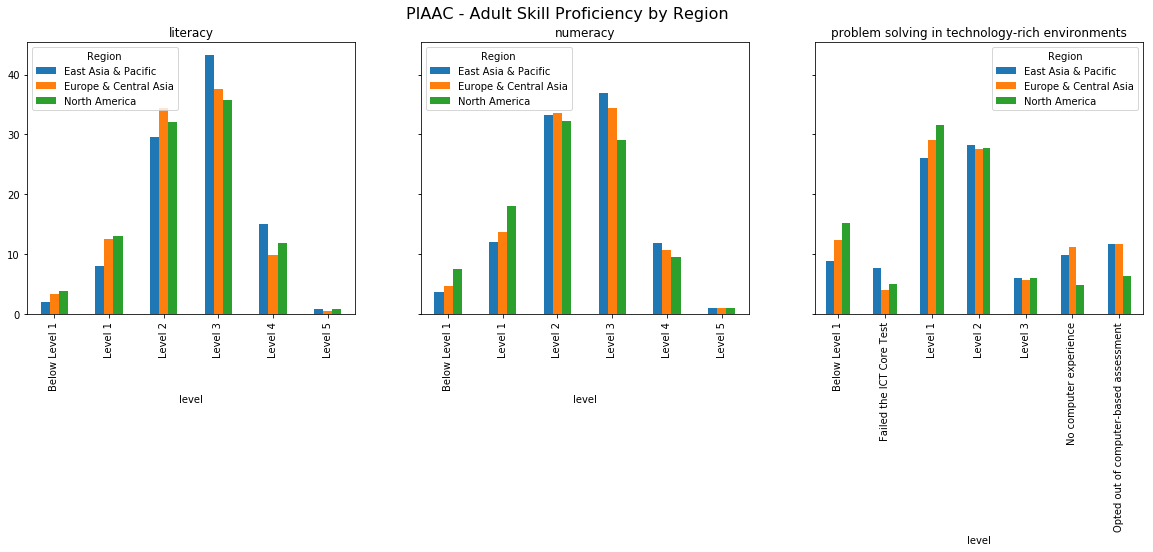

In [92]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
for i, sub in enumerate(['literacy', 'numeracy', 'problem solving in technology-rich environments']):
    tmp = df_adpr_clean[(df_adpr_clean['gender'] == 'Total') & (df_adpr_clean['subject'] == sub)][['Country Name', 'Region', 'level', '2012']]
    #print(tmp.groupby(['Region', 'level']).mean().reset_index().pivot(index='level', columns='Region', values='2012'))
    tmp.groupby(['Region', 'level']).mean().reset_index().pivot(index='level', columns='Region', values='2012').dropna(axis=1, how='all').plot.bar(ax=axs[i], title=sub);

    
fig.suptitle("PIAAC - Adult Skill Proficiency by Region", fontsize=16)


Text(0.5, 0.9, 'PIAAC - Adult Skill Proficiency by Country')

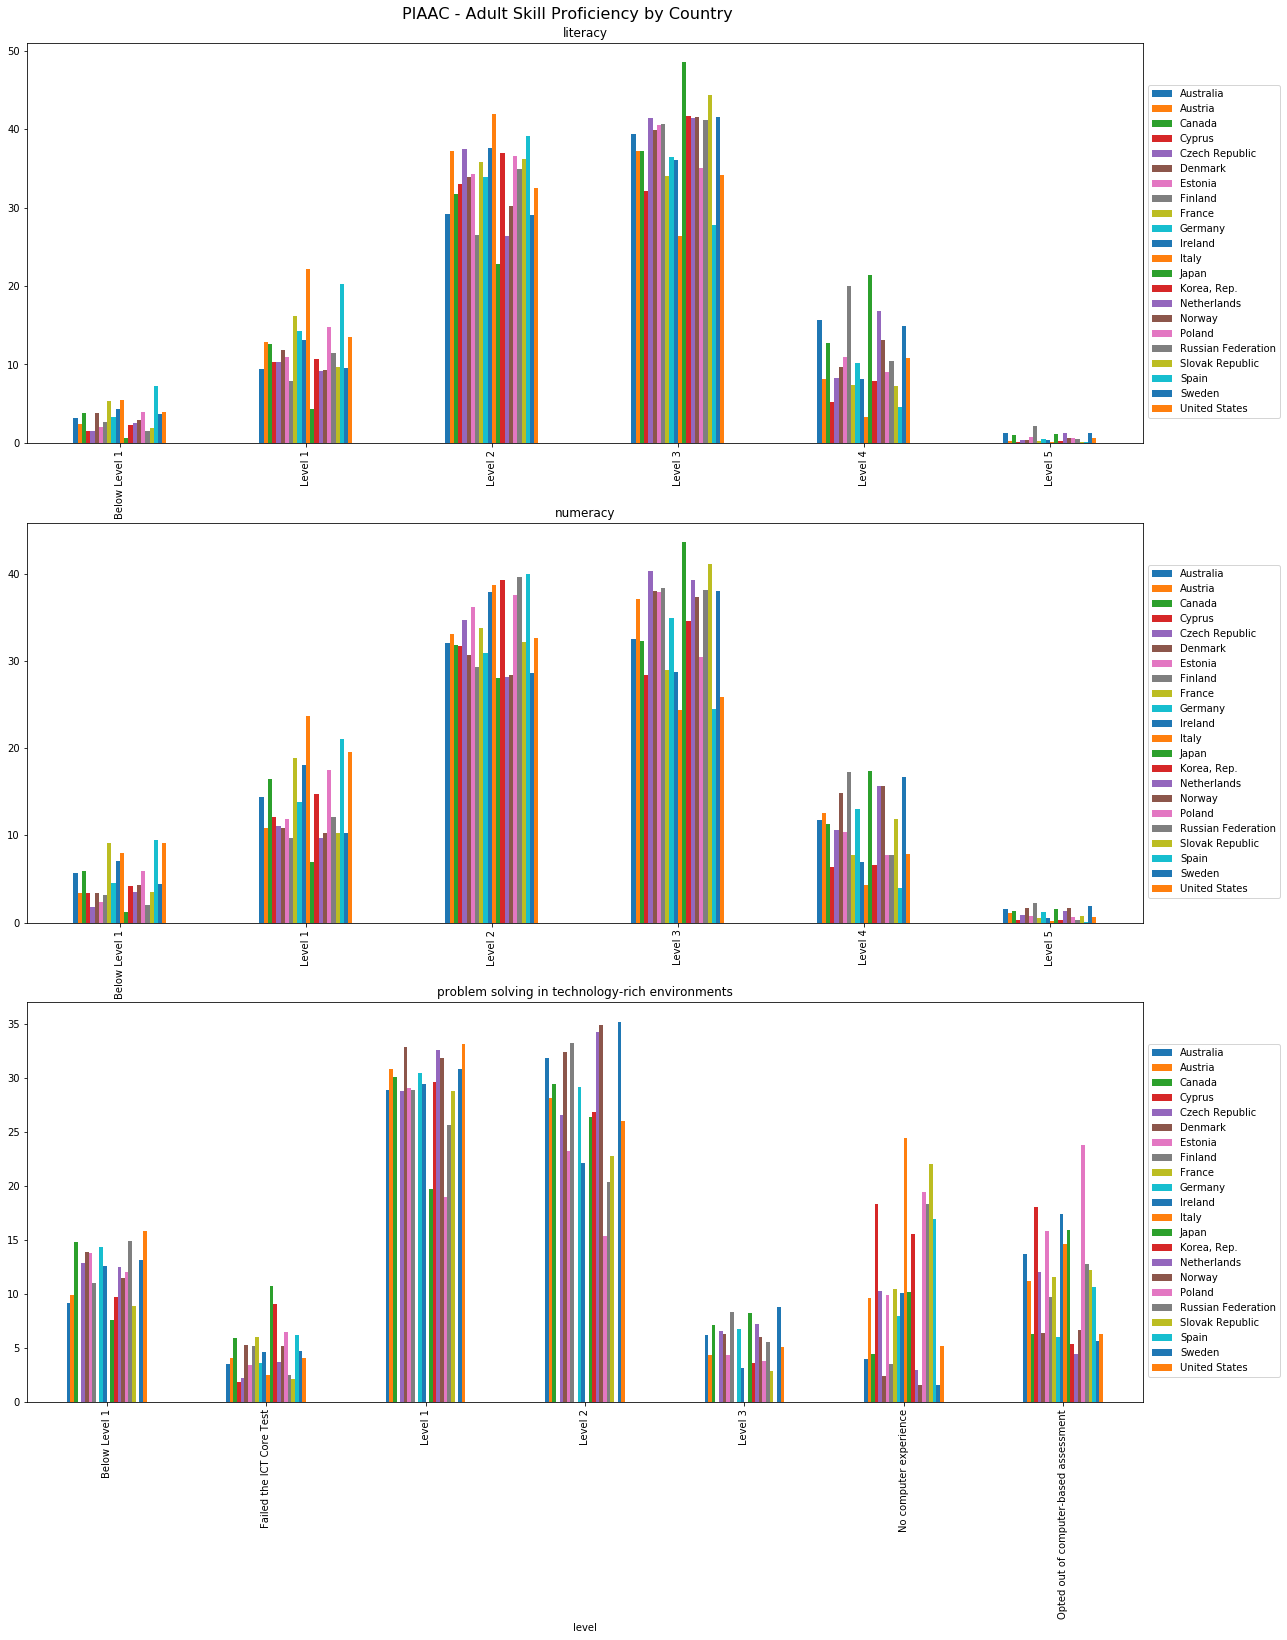

In [93]:
fig, axs = plt.subplots(3, 1, sharey=False, figsize=(20, 25))
for i, sub in enumerate(['literacy', 'numeracy', 'problem solving in technology-rich environments']):
    tmp = df_adpr_clean[(df_adpr_clean['gender'] == 'Total') & (df_adpr_clean['subject'] == sub)][['Country Name', 'Region', 'level', '2012']]
    #print(tmp.groupby(['Region', 'level']).mean().reset_index().pivot(index='level', columns='Region', values='2012'))
    tmp.groupby(['Country Name', 'level']).mean().reset_index().pivot(index='level', columns='Country Name', values='2012').dropna(axis=1, how='all').plot.bar(ax=axs[i], title=sub);
    patches, labels = axs[i].get_legend_handles_labels()
    axs[i].legend(patches, labels, loc='lower left', bbox_to_anchor=(1., .05, .0, .0))
fig.suptitle("PIAAC - Adult Skill Proficiency by Country", fontsize=16, y=.9)

Unfortunatly, the data we have is quite sparse and it only provides information from developed nations at this point. Here are a few interesting observations from the data:

* reading and math skills appear to be distributed in a similar manner (with math being the skill that people tend to be a bit worse at) (~2-5% below level 1)
* tech-rich problem solving is far less common, with many people (~20-30% of all people failing the test or are below level 1)
* Most of the difference evaporate on a regional level (with east-asia & pacific region having slightly more people in most higher level categories)
* Poland specifically appears to have many people without computational knowledge (there also seems to be a low bias in that regard in most baltic countries seen here)
* Scandinavian countries (esp. Sweden and Finland) appear to score high on numeracy and literacy tests.

## How long is the average education?

In the next step, we will look at the average years of schooling:

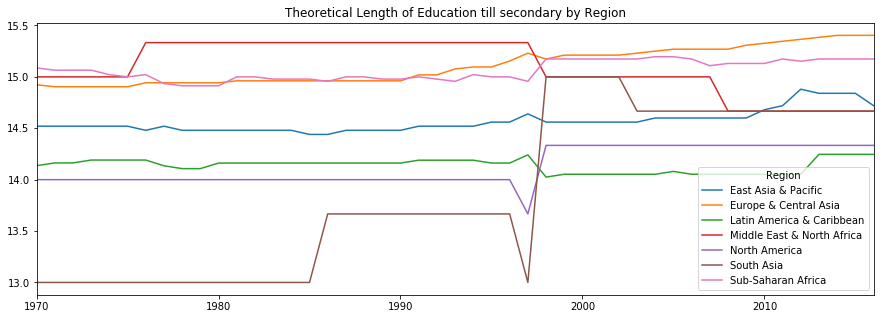

In [141]:
df_years = edstats.append_region(df_ed_years.dropna(axis=1, how='all'), df_country)
df_years = df_years[df_years.iloc[:, 4:-1].isnull().max(axis=1) == False]

#print(df_years['Indicator Name'].unique())

ls_inds = ['SE.SEC.DURS.LO', 'UIS.THDUR.0', 'SE.PRM.DURS', 'SE.SEC.DURS.UP'] #'SE.SEC.DURS', 
df_years[df_years['Indicator Code'].isin(ls_inds)].groupby(['Region', 'Indicator Name']).mean().groupby('Region').sum().transpose().plot(figsize=(15, 5), title="Theoretical Length of Education till secondary by Region")


The education length data is available for far more countries that our other dataset. In this case we see, that `South Asia` appears to have the lowest theoretical education length, while `Europe & Central Asia` have the longest with ~15.4 years.

## Putting it together

Now that we have both these datasets, our goal is to put it together and look at the correlation between average schooling years and proficiency in the skills (`literacy`, `numeracy` and `tech problem solving`). As we only have the latter data for the year 2012, we will limit our focus in this year:

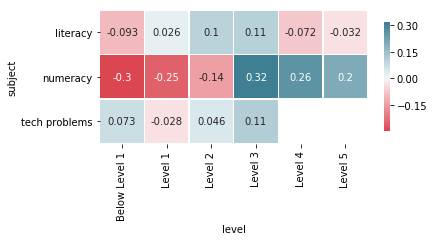

In [195]:
# retrieve education length for 2012
df_years12 = df_years[['Country Name', 'Country Code', 'Indicator Name', '2012', 'Region']][df_years['Indicator Code'].isin(ls_inds)]
df_years12 = df_years12.groupby(['Country Name', 'Region', 'Country Code']).sum().reset_index()

# retrieve proficiency for 2012
df_prof12 = df_adpr_clean[['Country Name', 'Country Code', 'gender', 'subject', 'level', 'Region', '2012']]

# merge the data
df_12 = pd.merge(df_prof12, df_years12, on='Country Code')[['Country Name_x', 'Country Code', 'Region_x', 'gender', 'subject', 'level', '2012_x', '2012_y']].rename(columns={
    'Country Name_x':'country_name',
    'Country Code':'country_code',
    'Region_x': 'region',
    '2012_x':'ppl_perc',
    '2012_y':'edu_length'}).replace('problem solving in technology-rich environments', 'tech problems')

# check the correlation for the different value combinations
combs = df_12.groupby(['subject', 'level', 'gender']).sum().index.tolist()
ds = []
for sub, lvl, gnd in combs:
    df_tmp = df_12[(df_12['subject'] == sub) & (df_12['level'] == lvl) & (df_12['gender'] == gnd)]
    corr = df_tmp['ppl_perc'].corr(df_tmp['edu_length'])
    ds.append([sub, lvl, gnd, corr])
df_corr = pd.DataFrame(ds, columns=['subject', 'level', 'gender', 'corr'])
df_corr = df_corr[(df_corr['gender'] == 'Total') & (df_corr['level'].isin(['Below Level 1', 'Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5']))].pivot(index='subject', columns='level', values='corr')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_corr, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

Now that we have looked at the correlation on a global level, lets look at it on a finer-grained level. Since we have only one datapoint per country (due to sparsity of skill data), we cannot compute meaningful correlation on a country level. However, we can do so on a regional level:

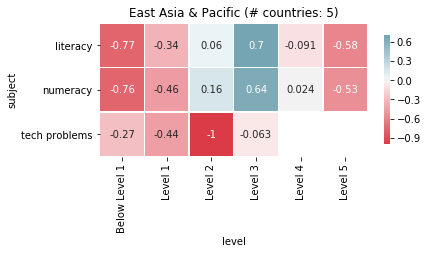

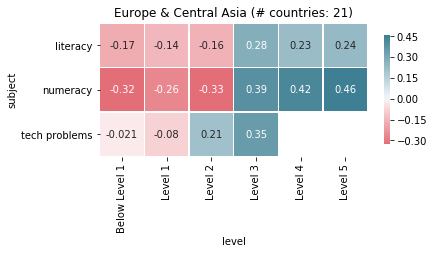

In [194]:
# retrieve all regions
ls_regions = df_12['region'].unique()

for reg in ls_regions:
    # check if enough countries
    no_countries = len(df_12[df_12['region'] == reg]['country_name'].unique())
    if no_countries < 5: continue
        
    # check the correlation for the different value combinations
    ds = []
    for sub, lvl, gnd in combs:
        df_tmp = df_12[(df_12['subject'] == sub) & (df_12['level'] == lvl) & (df_12['gender'] == gnd) & (df_12['region'] == reg)]
        corr = df_tmp['ppl_perc'].corr(df_tmp['edu_length'])
        ds.append([sub, lvl, gnd, corr])
    df_corr = pd.DataFrame(ds, columns=['subject', 'level', 'gender', 'corr'])
    df_corr = df_corr[(df_corr['gender'] == 'Total') & (df_corr['level'].isin(['Below Level 1', 'Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5']))].pivot(index='subject', columns='level', values='corr')

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 220, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    ax = plt.axes()
    sns.heatmap(df_corr, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, ax=ax)
    ax.set_title("{} (# countries: {})".format(reg, no_countries))
    plt.show()

In [192]:
df_12[df_12['region'] == 'Europe & Central Asia']['country_name'].unique()

array(['Austria', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy',
       'Lithuania', 'Netherlands', 'Norway', 'Poland',
       'Russian Federation', 'Slovak Republic', 'Slovenia', 'Spain',
       'Sweden', 'Turkey'], dtype=object)

## Conclusion

We can see numeracy is correlated quite strongly with the length of education (shorter longer education has a negative impact on Below Level 1 students and a positive impact on above level 3 students). Both other skills show not very strong correlations. Literacy shows a slight positive correlation for Level 2 & 3, but is basically not correlated for the remaining levels. Problem solving is also only slight correlated on level 3 (note that there are no levels 4 & 5 on the scale for this skill)

However, the data we are using here is extremely sparse and more data might very well shift the entire picture. Furthermore most of our data is coming from developed countries in the western hemisphere, meaning that might be other latent factors that influence the outcome.